In [1]:
print("Hello")

Hello


In [2]:
# requirements:
# numpy pandas scikit-learn imbalanced-learn matplotlib seaborn scipy
# Optional: tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from dataclasses import dataclass
from typing import Dict, Any, Tuple, List

from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, confusion_matrix,
    balanced_accuracy_score, precision_recall_curve, roc_curve, brier_score_loss,
    precision_score, recall_score
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Part A: Data & EDA
X, y = make_classification(
    n_samples=10_000,
    n_features=12,
    n_informative=6,
    n_redundant=2,
    n_repeated=0,
    n_classes=2,
    weights=[0.98, 0.02],
    class_sep=1.5,
    flip_y=0.01,
    random_state=RANDOM_SEED,
)
cols = [f"x{i}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=cols)
df["y"] = y


In [20]:
print(df.shape)
print(df.describe().T)

(10000, 13)
       count      mean       std        min       25%       50%       75%  \
x0   10000.0 -1.503850  1.241245  -6.509469 -2.343879 -1.510436 -0.670571   
x1   10000.0 -0.000743  2.106782  -6.008045 -1.615038 -0.147406  1.568652   
x2   10000.0  0.243588  2.596778 -12.168669 -1.492550  0.453633  2.125331   
x3   10000.0 -0.016580  2.153957  -6.700258 -1.623333 -0.177037  1.553136   
x4   10000.0 -1.484801  1.382232  -7.283496 -2.333005 -1.512829 -0.648681   
x5   10000.0  0.009197  1.000918  -3.940008 -0.677529  0.007193  0.678361   
x6   10000.0 -0.000103  0.991275  -3.726141 -0.664761  0.000517  0.670563   
x7   10000.0 -0.005311  1.014035  -4.462969 -0.675228 -0.002129  0.676037   
x8   10000.0  0.005530  0.993176  -3.705150 -0.659124  0.005403  0.668780   
x9   10000.0 -1.425596  1.589671  -8.064259 -2.488446 -1.445947 -0.403526   
x10  10000.0  0.020543  1.997377  -5.456626 -1.553051 -0.124733  1.538397   
x11  10000.0 -0.858600  2.098209 -12.541566 -2.051499 -0.350208 

In [5]:

minority_ratio = df["y"].mean()
print(f"Class distribution: minority={minority_ratio:.4f} (~{minority_ratio*100:.2f}%), "
      f"majority={(1-minority_ratio):.4f} (~{(1-minority_ratio)*100:.2f}%).")
print("Accuracy can be misleading with 98:2 skew because predicting all zeros yields ~98% accuracy, "
      "despite no positive detection. Prefer PR-AUC, F1/F2, balanced accuracy, and calibration-aware metrics.")

# Stratified train/val/test split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    df[cols].values, df["y"].values, test_size=0.15, stratify=df["y"].values, random_state=RANDOM_SEED
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1765, stratify=y_trainval, random_state=RANDOM_SEED
)  # 0.85 * 0.1765 ~= 0.15; net 70/15/15


Class distribution: minority=0.0245 (~2.45%), majority=0.9755 (~97.55%).
Accuracy can be misleading with 98:2 skew because predicting all zeros yields ~98% accuracy, despite no positive detection. Prefer PR-AUC, F1/F2, balanced accuracy, and calibration-aware metrics.


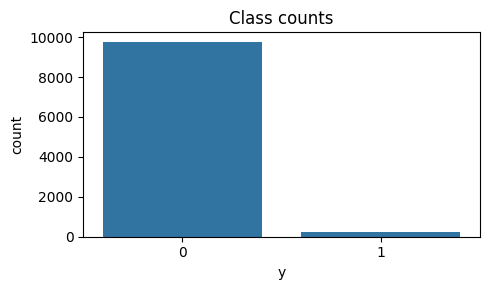

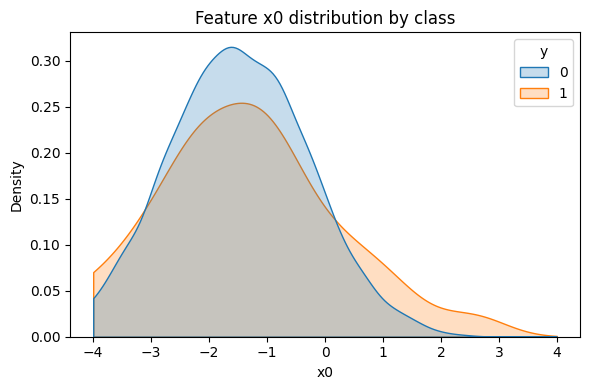

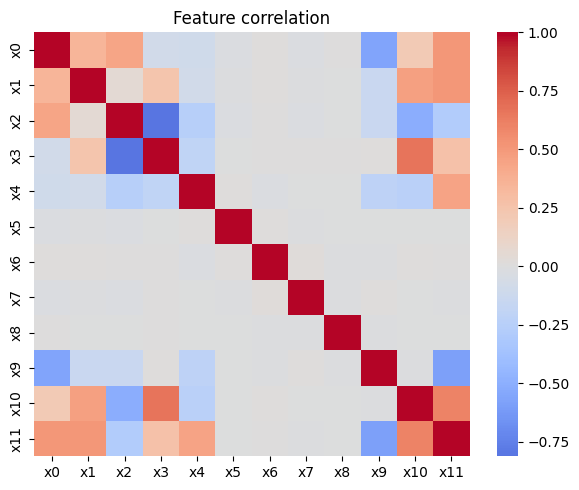

In [6]:

# Simple EDA plots
plt.figure(figsize=(5,3))
sns.countplot(x=df["y"])
plt.title("Class counts")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.kdeplot(x=df["x0"], hue=df["y"], common_norm=False, fill=True, clip=(-4,4))
plt.title("Feature x0 distribution by class")
plt.tight_layout()
plt.show()

corr = df[cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature correlation")
plt.tight_layout()
plt.show()


In [7]:
# Utilities
def precision_at_k(y_true, y_scores, k=100):
    idx = np.argsort(-y_scores)[:k]
    return y_true[idx].mean()

def compute_ci(values: List[float], alpha=0.95):
    m = np.mean(values)
    s = np.std(values, ddof=1)
    n = len(values)
    z = 1.96  # approx for 95%
    half = z * s / np.sqrt(n)
    return m, (m - half, m + half)

def evaluate_at_threshold(y_true, y_scores, thr):
    y_pred = (y_scores >= thr).astype(int)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f2 = fbeta(y_true, y_pred, beta=2)
    bal_acc = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    return {"threshold": thr, "F1": f1, "F2": f2, "BalancedAcc": bal_acc,
            "Precision": prec, "Recall": rec, "ConfusionMatrix": cm}

def fbeta(y_true, y_pred, beta=2):
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    if prec + rec == 0:
        return 0.0
    beta2 = beta**2
    return (1 + beta2) * prec * rec / (beta2 * prec + rec)

def find_best_threshold(y_true, y_scores, beta=1):
    ps, rs, ths = precision_recall_curve(y_true, y_scores)
    ths = np.append(ths, 1.0)  # align lengths
    if beta == 1:
        f = (2 * ps * rs) / (ps + rs + 1e-12)
    else:
        b2 = beta**2
        f = (1 + b2) * ps * rs / (b2 * ps + rs + 1e-12)
    idx = np.nanargmax(f)
    return float(ths[idx]), float(f[idx])

def plot_curves(y_true, y_scores, title_prefix=""):
    ps, rs, _ = precision_recall_curve(y_true, y_scores)
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    roc = roc_auc_score(y_true, y_scores)

    plt.figure(figsize=(5,4))
    plt.plot(rs, ps, label=f"PR-AUC={ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title_prefix} Precision-Recall Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f"ROC-AUC={roc:.3f}")
    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(f"{title_prefix} ROC Curve")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
# Part B: Baselines
def make_pipe(estimator):
    return Pipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("clf", estimator)
    ])

baselines = {
    "LR_base": make_pipe(LogisticRegression(max_iter=200, n_jobs=None, random_state=RANDOM_SEED)),
    "RF_base": make_pipe(RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1))
}

In [9]:
# Part C: Methods
def make_imb_pipeline(sampler, estimator):
    return ImbPipeline([
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("sampler", sampler),
        ("clf", estimator)
    ])

methods = {}
# Resampling
methods["LR_under"] = make_imb_pipeline(RandomUnderSampler(random_state=RANDOM_SEED),
                                        LogisticRegression(max_iter=200, random_state=RANDOM_SEED))
methods["LR_over"] = make_imb_pipeline(RandomOverSampler(random_state=RANDOM_SEED),
                                       LogisticRegression(max_iter=200, random_state=RANDOM_SEED))
methods["LR_smote"] = make_imb_pipeline(SMOTE(random_state=RANDOM_SEED, k_neighbors=5),
                                        LogisticRegression(max_iter=200, random_state=RANDOM_SEED))
methods["LR_adasyn"] = make_imb_pipeline(ADASYN(random_state=RANDOM_SEED, n_neighbors=5),
                                         LogisticRegression(max_iter=200, random_state=RANDOM_SEED))
methods["LR_smote_tomek"] = make_imb_pipeline(SMOTETomek(random_state=RANDOM_SEED),
                                              LogisticRegression(max_iter=200, random_state=RANDOM_SEED))
# Cost-sensitive
methods["LR_class_weight"] = make_pipe(LogisticRegression(max_iter=200, class_weight="balanced", random_state=RANDOM_SEED))
methods["RF_class_weight"] = make_pipe(RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=RANDOM_SEED, n_jobs=-1))


In [10]:
# Cross-validated evaluation
def cv_eval(model, X, y, k=5, calibrate=None):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)
    pr_aucs, roc_aucs, briers = [], [], []
    f1s_05, f2s_05, balaccs_05 = [], [], []
    f1s_opt, f2s_opt = [], []
    thresholds_f1, thresholds_f2 = [], []
    precis_at_100 = []
    runtimes = []
    for tr, va in skf.split(X, y):
        Xtr, Xva = X[tr], X[va]
        ytr, yva = y[tr], y[va]

        t0 = time()
        m = model
        m.fit(Xtr, ytr)
        if calibrate in ("sigmoid", "isotonic"):
            m = CalibratedClassifierCV(cv=3, method=calibrate)
        m.fit(Xtr, ytr)
        runtimes.append(time() - t0)

        if hasattr(m, "predict_proba"):
            p = m.predict_proba(Xva)[:,1]
        else:
            p = m.decision_function(Xva)
            p = (p - p.min()) / (p.max() - p.min() + 1e-12)

        ap = average_precision_score(yva, p)
        roc = roc_auc_score(yva, p)
        br = brier_score_loss(yva, p)
        pr_aucs.append(ap); roc_aucs.append(roc); briers.append(br)

        # Threshold 0.5
        res05 = evaluate_at_threshold(yva, p, 0.5)
        f1s_05.append(res05["F1"])
        f2s_05.append(res05["F2"])
        balaccs_05.append(res05["BalancedAcc"])

        # Precision@100
        precis_at_100.append(precision_at_k(yva, p, k=100))

        # Optimal thresholds for F1 and F2
        t_f1, f1opt = find_best_threshold(yva, p, beta=1)
        t_f2, f2opt = find_best_threshold(yva, p, beta=2)
        thresholds_f1.append(t_f1); thresholds_f2.append(t_f2)
        f1s_opt.append(f1opt); f2s_opt.append(f2opt)

    results = {
        "PR_AUC": pr_aucs, "ROC_AUC": roc_aucs, "Brier": briers,
        "F1@0.5": f1s_05, "F2@0.5": f2s_05, "BalancedAcc@0.5": balaccs_05,
        "F1@opt": f1s_opt, "F2@opt": f2s_opt, "Thr_F1": thresholds_f1, "Thr_F2": thresholds_f2,
        "P@100": precis_at_100, "RuntimeSec": runtimes
    }
    return results


In [11]:
def summarize_cv(res: Dict[str, List[float]]):
    summary = {}
    for k, v in res.items():
        m, (lo, hi) = compute_ci(v)
        summary[k] = {"mean": m, "ci95": (lo, hi)}
    return summary

def print_summary_table(name, summ):
    keys = ["PR_AUC","ROC_AUC","Brier","F1@0.5","F1@opt","F2@0.5","F2@opt","BalancedAcc@0.5","P@100","RuntimeSec"]
    row = [name] + [f"{summ[k]['mean']:.3f} [{summ[k]['ci95'][0]:.3f},{summ[k]['ci95'][1]:.3f}]" for k in keys]
    print("\t".join(["Model"] + keys))
    print("\t".join(row))

In [12]:
# Evaluate baselines
print("\n Part B: Baselines")
baseline_summaries = {}
for name, model in baselines.items():
    res = cv_eval(model, X_train, y_train, k=5, calibrate=None)
    summ = summarize_cv(res)
    baseline_summaries[name] = summ
    print_summary_table(name, summ)


 Part B: Baselines
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_base	0.652 [0.587,0.717]	0.891 [0.853,0.930]	0.013 [0.012,0.014]	0.572 [0.543,0.601]	0.670 [0.612,0.728]	0.466 [0.437,0.496]	0.648 [0.587,0.710]	0.707 [0.693,0.722]	0.256 [0.232,0.280]	0.036 [-0.011,0.082]
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
RF_base	0.777 [0.715,0.838]	0.901 [0.855,0.947]	0.010 [0.009,0.012]	0.688 [0.617,0.759]	0.783 [0.745,0.821]	0.585 [0.503,0.667]	0.769 [0.719,0.819]	0.766 [0.724,0.808]	0.282 [0.261,0.303]	2.807 [2.701,2.912]


In [13]:
# Evaluate methods (Part C)
print("\n Part C: Imbalance Mitigation")
method_summaries = {}
for name, model in methods.items():
    res = cv_eval(model, X_train, y_train, k=5, calibrate=None)
    summ = summarize_cv(res)
    method_summaries[name] = summ
    print_summary_table(name, summ)


 Part C: Imbalance Mitigation
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_under	0.593 [0.515,0.671]	0.876 [0.827,0.925]	0.110 [0.104,0.116]	0.214 [0.186,0.243]	0.608 [0.559,0.658]	0.378 [0.334,0.423]	0.590 [0.505,0.675]	0.820 [0.780,0.859]	0.242 [0.215,0.269]	0.009 [0.008,0.011]
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_over	0.634 [0.556,0.712]	0.886 [0.842,0.930]	0.098 [0.091,0.105]	0.235 [0.229,0.242]	0.654 [0.598,0.711]	0.405 [0.388,0.423]	0.638 [0.551,0.725]	0.831 [0.800,0.862]	0.252 [0.228,0.276]	0.019 [0.017,0.021]
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_smote	0.636 [0.566,0.706]	0.884 [0.843,0.926]	0.089 [0.082,0.095]	0.252 [0.240,0.264]	0.667 [0.609,0.725]	0.425 [0.404,0.447]	0.628 [0.562,0.694]	0.839 [0.808,0.870]	0.256 [0.232,0.280]	0.021 [0.019,0.023]
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	Ru

In [14]:
# Add calibration on top of a strong method (example: LR_smote)
print("\n=== Calibration Variants (on LR_smote) ===")
calib_variants = {}
for method in ["LR_smote"]:
    for calib in ["sigmoid", "isotonic"]:
        name = f"{method}+cal_{calib}"
        res = cv_eval(methods[method], X_train, y_train, k=5, calibrate=calib)
        summ = summarize_cv(res)
        calib_variants[name] = summ
        print_summary_table(name, summ)



=== Calibration Variants (on LR_smote) ===
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_smote+cal_sigmoid	0.651 [0.582,0.721]	0.890 [0.850,0.929]	0.013 [0.012,0.015]	0.560 [0.518,0.601]	0.671 [0.620,0.722]	0.454 [0.410,0.498]	0.642 [0.574,0.710]	0.701 [0.680,0.723]	0.258 [0.231,0.285]	0.029 [0.028,0.029]
Model	PR_AUC	ROC_AUC	Brier	F1@0.5	F1@opt	F2@0.5	F2@opt	BalancedAcc@0.5	P@100	RuntimeSec
LR_smote+cal_isotonic	0.636 [0.575,0.698]	0.887 [0.845,0.930]	0.013 [0.011,0.014]	0.620 [0.567,0.672]	0.670 [0.618,0.722]	0.540 [0.485,0.594]	0.640 [0.575,0.704]	0.747 [0.720,0.775]	0.258 [0.231,0.285]	0.025 [0.025,0.026]


In [15]:
# Quick ablation ladder printout by PR-AUC then F1@opt
def get_key(summ): return (summ["PR_AUC"]["mean"], summ["F1@opt"]["mean"])
all_summ = {**baseline_summaries, **method_summaries, **calib_variants}
ranked = sorted(all_summ.items(), key=lambda kv: get_key(kv[1]), reverse=True)
print("\n=== Part D: Ablation/Ranking (by PR-AUC then F1@opt) ===")
for i, (name, summ) in enumerate(ranked[:8], 1):
    print(f"{i}. {name}: PR_AUC={summ['PR_AUC']['mean']:.3f}, F1@opt={summ['F1@opt']['mean']:.3f}")



=== Part D: Ablation/Ranking (by PR-AUC then F1@opt) ===
1. RF_class_weight: PR_AUC=0.809, F1@opt=0.852
2. RF_base: PR_AUC=0.777, F1@opt=0.783
3. LR_base: PR_AUC=0.652, F1@opt=0.670
4. LR_smote+cal_sigmoid: PR_AUC=0.651, F1@opt=0.671
5. LR_smote+cal_isotonic: PR_AUC=0.636, F1@opt=0.670
6. LR_smote: PR_AUC=0.636, F1@opt=0.667
7. LR_smote_tomek: PR_AUC=0.636, F1@opt=0.667
8. LR_over: PR_AUC=0.634, F1@opt=0.654


In [16]:
# Pick best configuration
best_name, best_summary = ranked[0]
best_model = None
if best_name in baselines:
    best_model = baselines[best_name]
elif best_name in methods:
    best_model = methods[best_name]
else:
    # If calibrated variant won, recreate that calibrated wrapper after fitting on train+val
    base = methods["LR_smote"]
    best_model = ("calibrated", base)

print(f"\nSelected best config: {best_name}")



Selected best config: RF_class_weight


In [17]:
# Fit best on train+val and evaluate once on test
def fit_and_eval_final(model, X_tr, y_tr, X_te, y_te, calibrate=None):
    m = model
    if calibrate:
        m = CalibratedClassifierCV(estimator=m, cv=5, method=calibrate)
    m.fit(X_tr, y_tr)
    if hasattr(m, "predict_proba"):
        p = m.predict_proba(X_te)[:,1]
    else:
        s = m.decision_function(X_te)
        p = (s - s.min()) / (s.max() - s.min() + 1e-12)

    ap = average_precision_score(y_te, p)
    roc = roc_auc_score(y_te, p)
    br = brier_score_loss(y_te, p)
    t_f1, f1opt = find_best_threshold(y_te, p, beta=1)
    t_f2, f2opt = find_best_threshold(y_te, p, beta=2)
    res05 = evaluate_at_threshold(y_te, p, 0.5)
    res_f1 = evaluate_at_threshold(y_te, p, t_f1)
    res_f2 = evaluate_at_threshold(y_te, p, t_f2)

    print("\n=== Part D: Test-set Evaluation (once) ===")
    print(f"PR-AUC={ap:.3f} | ROC-AUC={roc:.3f} | Brier={br:.3f}")
    print(f"Threshold 0.5: F1={res05['F1']:.3f}, F2={res05['F2']:.3f}, BalancedAcc={res05['BalancedAcc']:.3f}")
    print(f"Best F1 thr={t_f1:.3f}: F1={res_f1['F1']:.3f}, P={res_f1['Precision']:.3f}, R={res_f1['Recall']:.3f}")
    print(f"Best F2 thr={t_f2:.3f}: F2={res_f2['F2']:.3f}, P={res_f2['Precision']:.3f}, R={res_f2['Recall']:.3f}")
    print("Confusion Matrix @ best F1:\n", res_f1["ConfusionMatrix"])

    plot_curves(y_te, p, title_prefix="Best model")

    return p


=== Part D: Test-set Evaluation (once) ===
PR-AUC=0.790 | ROC-AUC=0.872 | Brier=0.010
Threshold 0.5: F1=0.655, F2=0.542, BalancedAcc=0.743
Best F1 thr=0.240: F1=0.866, P=0.967, R=0.784
Best F2 thr=0.240: F2=0.815, P=0.967, R=0.784
Confusion Matrix @ best F1:
 [[1462    1]
 [   8   29]]


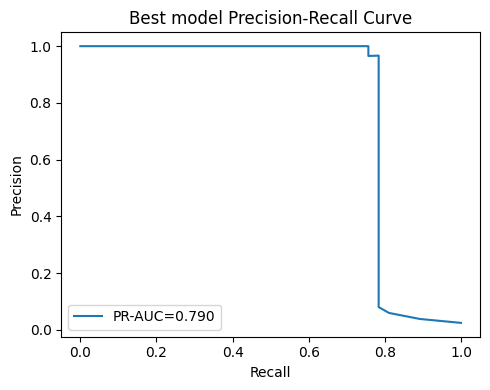

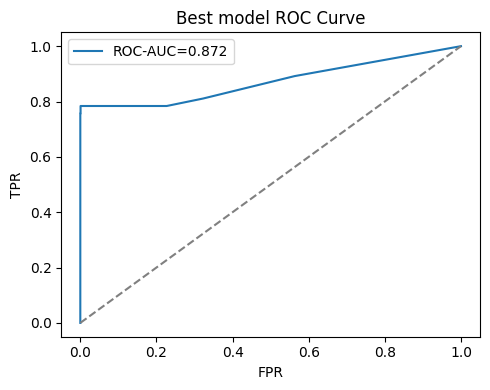


=== Part E: Theory Notes ===
PR-AUC vs ROC-AUC under imbalance:
- ROC-AUC can look high because true negatives dominate FPR when positives are rare,
  while PR-AUC focuses on precision/recall for the minority and penalizes false positives.
F1 maximization:
- F1 = 2PR/(P+R). For a fixed average of P and R, the harmonic mean is maximized when P=R;
  along a threshold sweep, the maximum occurs near P≈R, giving the F1-optimal threshold.
Prior shift:
- If positive prior changes between train and test, calibrated probabilities and thresholds
  tuned on train priors become misaligned; recalibration or prior-adjusted thresholds is advised.


In [ ]:
# Prepare full train+val for final fit
X_tr_full = np.vstack([X_train, X_val])
y_tr_full = np.concatenate([y_train, y_val])

if best_name.endswith("+cal_sigmoid"):
    fit_and_eval_final(methods["LR_smote"], X_tr_full, y_tr_full, X_test, y_test, calibrate="sigmoid")
elif best_name.endswith("+cal_isotonic"):
    fit_and_eval_final(methods["LR_smote"], X_tr_full, y_tr_full, X_test, y_test, calibrate="isotonic")
else:
    fit_and_eval_final(best_model, X_tr_full, y_tr_full, X_test, y_test, calibrate=None)

print("\n=== Part E: Theory Notes ===")
print("PR-AUC vs ROC-AUC under imbalance:")
print("- ROC-AUC can look high because true negatives dominate FPR when positives are rare,")
print("  while PR-AUC focuses on precision/recall for the minority and penalizes false positives.")
print("F1 maximization:")
print("- F1 = 2PR/(P+R). For a fixed average of P and R, the harmonic mean is maximized when P=R;")
print("  along a threshold sweep, the maximum occurs near P≈R, giving the F1-optimal threshold.")
print("Prior shift:")
print("- If positive prior changes between train and test, calibrated probabilities and thresholds")
print("  tuned on train priors become misaligned; recalibration or prior-adjusted thresholds is advised.")
